In [1]:
import os
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader

sys.path.append(os.path.join(sys.path[0], '../src'))
import data
import utils
import model
from model import EncoderRNN
from model import DecoderRNN

%load_ext autoreload
%autoreload 2

## Load and process training data

In [2]:
# Change to directory containing English to Tamil transliteration data.
DATA_DIR = "../data/aksharantar_sampled/tam/"
os.chdir(DATA_DIR)
os.listdir()

['dataset.pkl', 'tam_test.csv', 'tam_train.csv', 'tam_valid.csv']

The class WordDataset reads and stores words in onehot representation.

In [3]:
# dataset = data.WordDataset() # By default reads 'tam_train.csv'.
# with open('dataset.pkl', 'wb') as file:
    # pickle.dump(dataset, file)

In [4]:
with open('dataset.pkl', 'rb') as file:
    dataset = pickle.load(file)

The above object `dataset[i]` returns i-th data point: a word-pair in one-hot represenation. 

In [5]:
x, y = dataset[0]
print(x.shape)
print(y.shape)

torch.Size([50, 128])
torch.Size([50, 128])


In [6]:
dataset.decode_eng_word(x)

'thottacharya'

In [7]:
dataset.decode_tam_word(y)

'தொட்டாச்சார்ய'

### Sampling data

In [8]:
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
next(iter(train_dataloader))

[tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [1, 0, 0,  ..., 0, 0, 0],
          [1, 0, 0,  ..., 0, 0, 0],
          [1, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [1, 0, 0,  ..., 0, 0, 0],
          [1, 0, 0,  ..., 0, 0, 0],
          [1, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32)]

## Test Encoder

In [9]:
from model import EncoderRNN
encoder = EncoderRNN(cell_type='gru')
output, hidden = encoder.forward(x)

In [10]:
out = torch.sum(output)
out.backward()

In [11]:
for param in encoder.parameters():
    print(param.grad)

tensor([[0.4285, 0.6735, 0.3540,  ..., 0.5020, 0.2634, 1.4263],
        [0.8637, 1.2613, 0.1914,  ..., 0.4129, 0.4577, 0.0513],
        [0.5592, 0.5802, 0.5884,  ..., 0.0262, 0.3747, 0.9818],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[ 5.4498e-01, -6.6377e-02,  4.4507e-01,  ..., -4.7620e-02,
         -5.4587e-01, -3.2954e-01],
        [ 1.4870e-01, -1.9425e-01, -6.9638e-01,  ..., -6.5899e-02,
          2.5672e-01,  2.7203e-01],
        [ 6.4079e-02, -1.4422e-01, -2.1869e-02,  ...,  1.6980e-02,
         -2.8359e-03,  1.3072e-01],
        ...,
        [-9.9304e+00,  1.4111e+00,  1.0147e+01,  ...,  6.0287e+00,
          5.3456e+00, -9.0902e+00],
        [ 9.0642e-01, -1.7048e+00,  1.5344e+01,  ..., -5.6512e+00,
          5.4690e+00, -1.7166e+01],
        [-4.6495e+00,  3.5409e+00,  7.8673e+00,  ...,  6.5576e-01,
       

In [12]:
print(output.shape)
print(hidden.shape)

torch.Size([50, 16])
torch.Size([1, 16])


### Decoder

In [13]:
y[0].shape

torch.Size([128])

In [14]:
import model
from model import DecoderRNN

decoder = DecoderRNN(cell_type='gru')
out, hidden = decoder.forward(y[0], hidden)

/mnt/d/courses/cs6910_dl/assignment_3/notebooks/../src/model.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.out_act(output)


In [15]:
hidden.shape

torch.Size([1, 16])

In [16]:
print(out.shape)
print(hidden.shape)

torch.Size([1, 128])
torch.Size([1, 16])


## Loss

In [17]:
target = torch.zeros(128)
target[0] = 1
target = torch.tensor([torch.where(target == 1)[0]])
y_hat = out
criterion = nn.NLLLoss()
loss = criterion(y_hat, target)

In [18]:
for param in encoder.parameters():
    print(param.grad)
    break

tensor([[0.4285, 0.6735, 0.3540,  ..., 0.5020, 0.2634, 1.4263],
        [0.8637, 1.2613, 0.1914,  ..., 0.4129, 0.4577, 0.0513],
        [0.5592, 0.5802, 0.5884,  ..., 0.0262, 0.3747, 0.9818],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


## Test Training

Code prior to calling `train`

In [19]:
encoder = EncoderRNN(cell_type='lstm')
decoder = DecoderRNN(cell_type='lstm')

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr = 100)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr = 100)
criterion = nn.NLLLoss()

In [20]:
# def train_onestep(dataset, encoder, decoder, )

In [21]:
x, y = next(iter(dataset))

In [22]:
x.shape

torch.Size([50, 128])

In [23]:
Embed = nn.Embedding(128, 16)
embeded = Embed(torch.where(x[0] == 1)[0])
embeded
model = nn.RNN(16, 16)
hidden = torch.zeros(16).view(1, 16)
print(embeded.shape)
print(hidden.shape)
output, hidden = model(embeded)

torch.Size([1, 16])
torch.Size([1, 16])


In [31]:
loss = utils.train_one_iter(x, y, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

In [32]:
encoder, decoder, loss_seq = utils.train(dataset, 0.01, 2000)

100%|██████████| 2000/2000 [00:40<00:00, 49.80it/s]


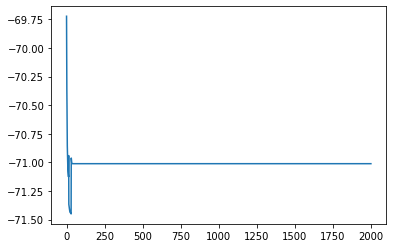

In [26]:
plt.plot(loss_seq)

## Evaluation

In [27]:
x, y = next(iter(dataset))

In [28]:
encoder.initialize_hidden()

In [29]:
y_pred = utils.predict(x, encoder, decoder)

In [30]:
torch.sum(y_pred)
dataset.decode_tam_word(y_pred)
# dataset.decode_tam_word(y)

'ஙங\u0bdcவஇவவ\u0be4இவ\u0babஇவ\u0babஇவ\u0babஇவ\u0babஇவ\u0babஇவ\u0babஇவ\u0babஇவ\u0babஇவ\u0babஇவ\u0babஇவ\u0babஇவ\u0babஇவ\u0babஇவ\u0bab'